# Tutorial 2: Implementing perils in the GenMR digital template


**Author:** Arnaud Mignan, Mignan Risk Analytics GmbH  
**Version:** 0.1  
**Last Updated:** 2025-11-19   
**License:** [AGPL-3](https://opensource.org/license/agpl-v3) 

Once a virtual environment has been generated (see previous tutorial), stochastic events are modelled to populate it. Table 1 lists the perils so far considered in version 1.1.1 as well as the ones to be added in the near future (v. 1.1.2).

<br>
<center><small><b>Tab. 1.</b> List of perils with identifiers (ID) according to <a href='https://www.cambridge.org/highereducation/books/introduction-to-catastrophe-risk-modelling/A3A5B5FB990921422BFEBB07734BF869#overview' target='_blank'>Mignan (2024:tab.1.7)</a>.</small></center>

| ID | Peril | Peril type | Source class | Event size | Intensity class | Intensity measure | Status<sup>&#8224;</sup> |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
|  | **NATURAL** |  |  |  |  |  |  |
| `AI` | Asteroid impact | Primary | Point | Kinetic energy (kt) | Analytical | Overpressure (kPa) | <span style="color: green">&#x2713;<span> |
| `Dr` | Drought |  |  |  |  |  | <span style="color: orange">&#x2717;<span> |
| `EQ` | Earthquake | Primary | Line | Magnitude | Analytical | Peak ground acceleration (m/s$^2$) | <span style="color: green">&#x2713;<span> |
| `FF` | Fluvial flood | Secondary (to `RS`) | Point | Peak flow | Cellular automaton | Inundation depth (m) | <span style="color: green">&#x2713;<span> |
| `HW` | Heatwave |  |  |  |  |  | <span style="color: orange">&#x2717;<span> |
| `Li` | Lightning |  |  |  |  |  | <span style="color: orange">&#x2717;<span> |
| `LS` | Landslide | Secondary (to `RS`) | Diffuse | Area (km$^2$) | Cellular automaton | Thickness (m) | <span style="color: green">&#x2713;<span> |
| `PI` | Pest infestation |  |  |  |  |  | <span style="color: orange">&#x2717;<span> |
| `RS` | Rainstorm | Primary (invisible$^*$) | Area | Rain intensity (mm/hr) | Threshold | - | <span style="color: green">&#x2713;<span> |
| `SS` | Storm surge | Secondary (to `TC`) | Line | Coastal surge height (m) | Threshold | Inundation depth (m) | <span style="color: green">&#x2713;<span> |
| `TC` | Tropical cyclone | Primary | Track | Max. wind speed (m/s) | Analytical | Max. wind speed (m/s) | <span style="color: green">&#x2713;<span> |
| `To` | Tornado |  |  |  |  |  | <span style="color: orange">&#x2717;<span> |
| `VE` | Volcanic eruption | Primary | Point | Volume erupted (km$^3$) | Analytical | Ash load (kPa) | <span style="color: green">&#x2713;<span> |
| `WF` | Wildfire | Primary | Diffuse | Burnt area | Cellular automaton | Burnt/not burnt | <span style="color: green">&#x2713;<span> |
| `WS` | Windstorm |  |  |  |  |  | <span style="color: orange">&#x2717;<span> |
|  | **TECHNOLOGICAL** |  |  |  |  |  |  |
| `BO` | Blackout |  |  |  |  |  | <span style="color: orange">&#x2717;<span> |
| `Ex` | Explosion (industrial) | Secondary (to `dg`) | Point | TNT mass (kt) | Analytical | Overpressure $P$ (kPa) | <span style="color: green">&#x2713;<span> |
|  | **SOCIO-ECONOMIC** |  |  |  |  |  |  |
| `BI` | Business interruption |  |  |  |  |  | <span style="color: orange">&#x2717;<span> |
| `Sf` | Public service failure |  |  |  |  |  | <span style="color: orange">&#x2717;<span> |
| `SU` | Social unrest |  |  |  |  |  | <span style="color: orange">&#x2717;<span> |

<small>$^*$ Rainstorm is called an 'invisible peril' (following <a href='https://link.springer.com/article/10.1007/s11069-014-1178-4' target='_blank'>Mignan et al., 2014</a>) since it does not cause any direct damage in the present framework. It is implemented as both the landslide and fluvial flood triggering mechanism.<br>
               <sup>&#8224;</sup> To be included in current version 1.1.1 (<span style="color: green">&#x2713;</span>), planned for v.1.1.2 (<span style="color: orange">&#x2717;</span>).</small>


ADD TEXT

Figure 1 illustrates the relationship between some stochastic event footprints and the underlying environment:

<br>

```{figure} ../figures/digitaltemplate_ev_rayshader.png
:name: fig-digitaltemplate
:width: 500px
:align: center

**Fig. 1.** One instance of the GenMR digital template (default parameterisation) with an example of event hazard intensity footprint and loss footprint (here for a large earthquake). Simulation rendered using [Rayshader](https://www.rayshader.com/) (Morgan-Wall, 2022).

/Users/arnaudmignan/Documents/GmbH_MRA/2_fundedR&D/2025-2027_GenMR_SCOR/GenMR_SCOR/GenMR/environment.py:511: RuntimeWarning: divide by zero encountered in divide
  FS = (par['Ceff_Pa'] / (par['rho_kg/m3'] * GenMR_utils.g_earth * h) + np.cos(slope * np.pi/180) * \


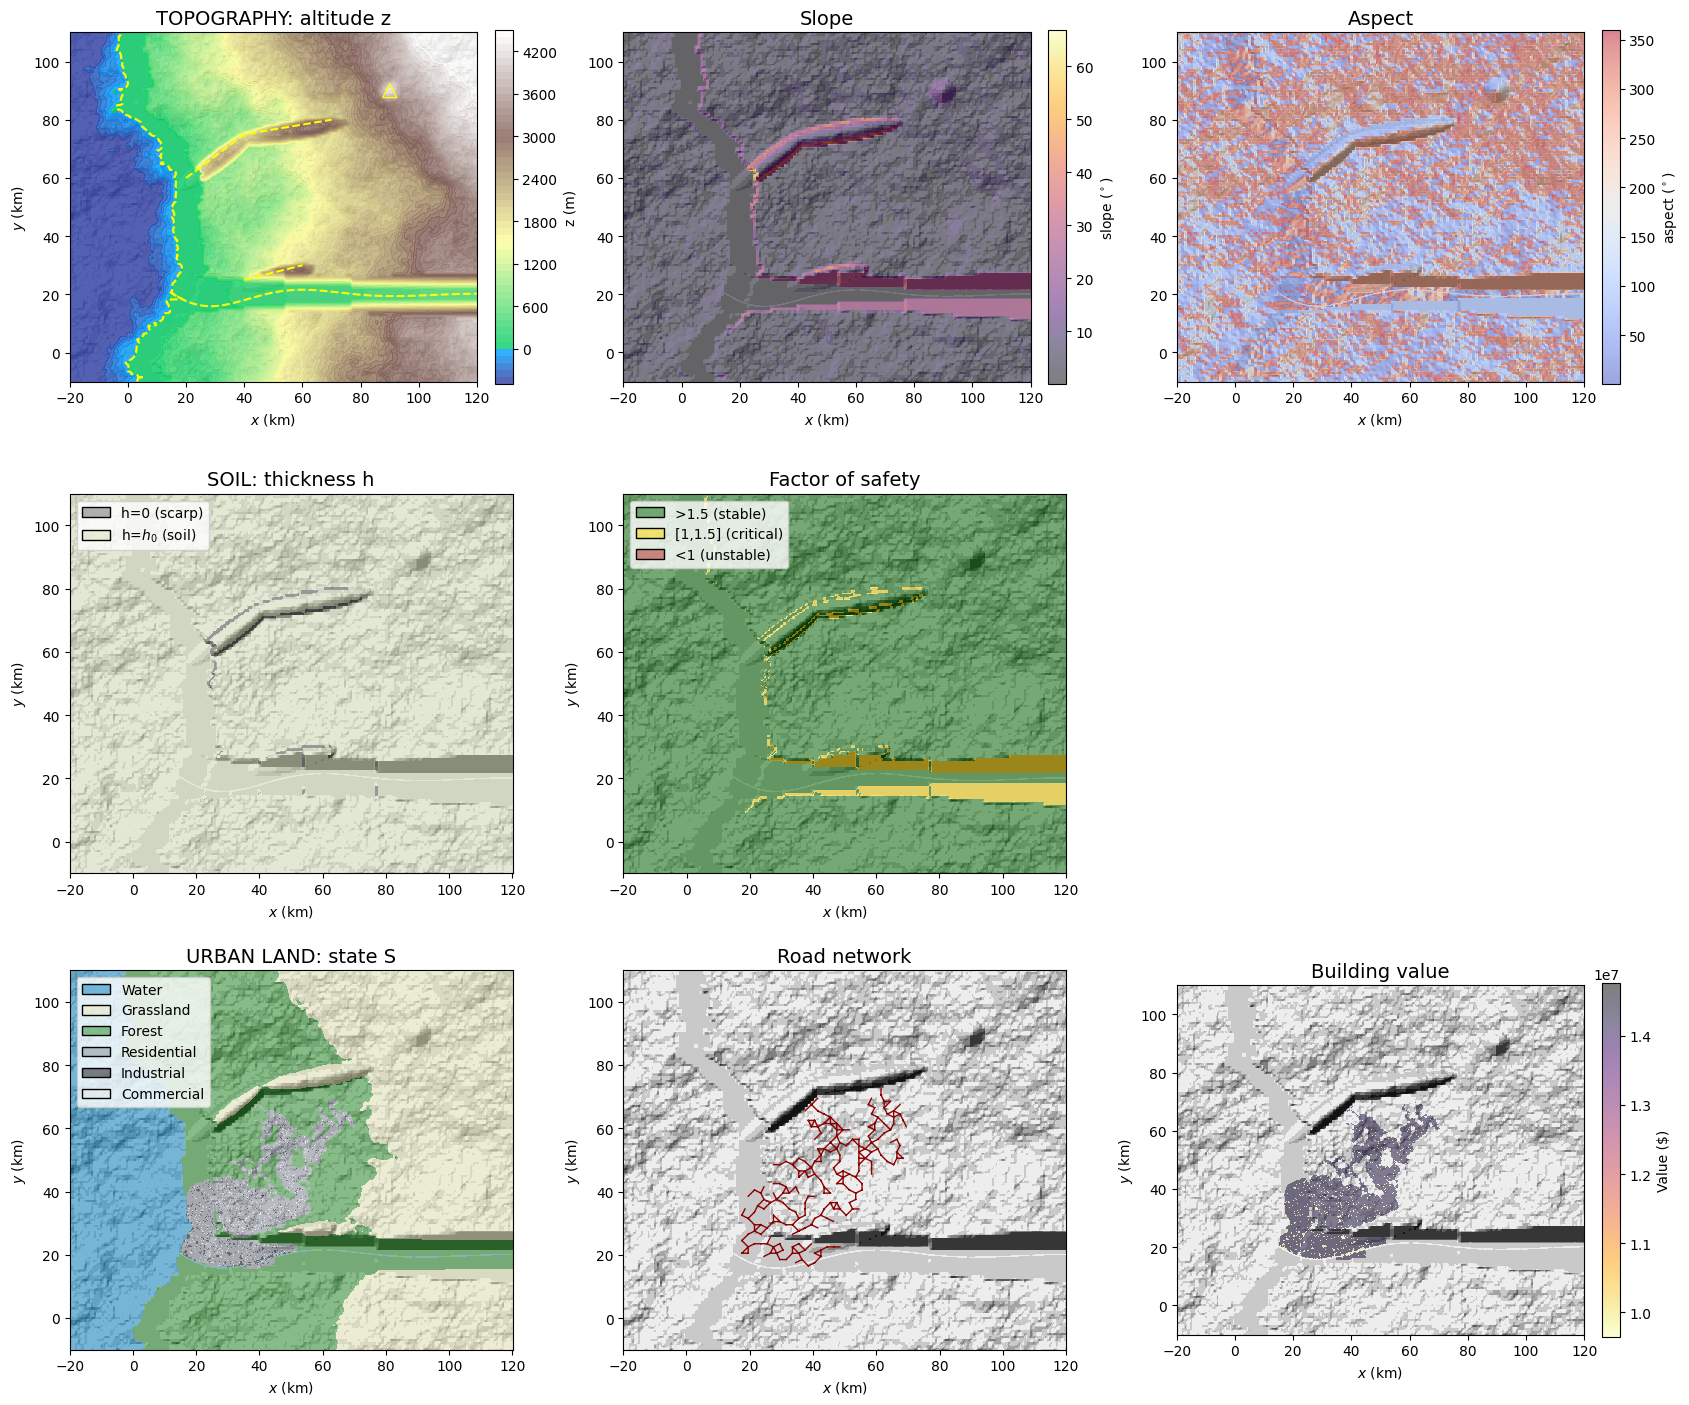

In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

#import warnings 
#warnings.filterwarnings('ignore')   # commented, try to remove all warnings

from GenMR import perils as GenMR_perils
from GenMR import environment as GenMR_env
from GenMR import utils as GenMR_utils


# load inputs (i.e., outputs from Tutorial 1)
file_src = 'src.pkl'
file_topoLayer = 'envLayer_topo.pkl'
file_soilLayer = 'envLayer_soil.pkl'
file_urbLandLayer = 'envLayer_urbLand.pkl'
src = GenMR_utils.load_pickle2class('/io/' + file_src)
grid = copy.copy(src.grid)
topoLayer = GenMR_utils.load_pickle2class('/io/' + file_topoLayer)
soilLayer = GenMR_utils.load_pickle2class('/io/' + file_soilLayer)
urbLandLayer = GenMR_utils.load_pickle2class('/io/' + file_urbLandLayer)

GenMR_env.plot_EnvLayers([topoLayer, soilLayer, urbLandLayer], file_ext = 'jpg')

Note that the configuration of the digital template environment may be changed through Tutorial 1.

## 1. Probabilistic hazard assessment

Event independence is assumed, except for ad-hoc 1-to-1 peril deterministic triggering (e.g., a tropical cyclone triggers a storm surge)...

### 1.1. Peril source definition

Source characteristics were defined in Tutorial 1 for earthquakes, volcanic eruptions and fluvial floods (due to environmental layer dependence on these perils). Additional localised peril sources (`AI`, `SS`, `TC`) will now be introduced, which have no direct impact on the environmental layers currently defined.

TO DEVELOP/REWRITE

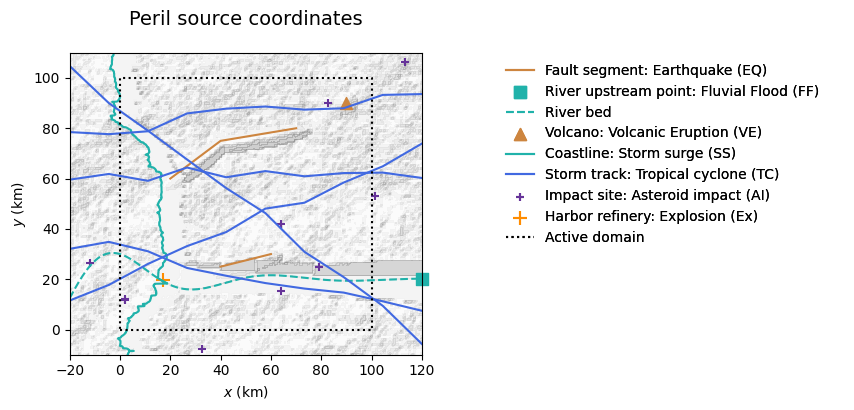

In [2]:
src.par['perils'] = ['AI','EQ','RS','TC','VE', 'FF','LS','SS','Ex']    # IMPORTANT: primary perils come first
src.par['rdm_seed'] = 42      # None or integer (for stochastic sources: AI, TC)


# define new perils
src.par['AI'] = {'object': 'impact', 'N': 10}     # random uniform asteroid impacts (point sources)
src.par['LS'] = {'object': 'terrain'}
src.par['RS'] = {'object': 'atmosphere',          # as trigger of landslides
                 'duration': 24}                  # (hr) to calc. soil wetness that triggers LS & FF discharge
                                                  # WARNING: constant for now, to be improved

src.par['SS'] = {'object': 'coastline'}
SS_src_xi, SS_src_yi = topoLayer.coastline_coord
src.SS_char = {'x': SS_src_xi, 'y': SS_src_yi}

src.par['TC'] = {'object': 'stormtrack', 'N': 5,  # pseudo-random track sources moving from West to East
                 'npt': 10,      # number of points along track, which crosses the grid from West to East
                 'max_dev': 3,   # random uniform deviation along the y-axis at each track point
                 'bin_km': 1.}   # track spatial resolution

# WARNING: slow the first time it is called:
CI_x, CI_y = urbLandLayer.CI_refinery.centroid
src.par['Ex'] = {'object': 'refinery', 'N': 1, 'x': CI_x, 'y': CI_y}  # harbor refinery as source of explosions

GenMR_perils.plot_src(src, hillshading_z = topoLayer.z, file_ext = 'jpg')

**NOTE:** Hazard intensity footprints are modeled based on the sources shown in the map above. For stochastic sources (`AI`, `TC`), rerunning the previous cell will produce different configurations unless `rdm_seed` is fixed.

### 1.2. Stochastic event set generation

The stochastic event set (or event table) consists of a list of events per peril with identifier `evID`, size `S`, and rate `lbd`. Two types of perils will be considered: primary perils for which the rate of occurrence must be assessed and secondary perils which will be assumed-in this tutorial-to occur in pair with their triggers. In this case, to keep working with an event table (and not a simulation table and adjacency matrix of interactions; see future Tutorial 3), each trigger event here has a probability of one to cause one target event. Note also that `Ex`, `FF` and `WF` events are not implemented in the stochastic set but will be considered at a later stage to illustrate specific aspects associated to the virtual region. TO DO: add explosions here already...
* Primary perils: `AI`, `EQ`, `RS`, `TC`, `VE`
* Secondary perils: `LS` and `FF` triggered by `RS` and `SS` triggered by `TC`, `Ex` triggered by damage

This is parameterised in the dictionary `sizeDistr` with:
* Event size incrementation according `Smin`, `Smax` and `Sbin` with binning in `linear` or `log` scale.
* Event size distribution modelled by one of 3 functions: power-law (Mignan, 2024:Eq. 2.38), exponential law (Mignan, 2024:Eq. 2.39), or Generalised Pareto Distribution (GPD, Mignan, 2024:Eq. 2.50).
* Rates of the digital template are for most perils simply calibrated by taking the ratio of the region area to the area used to obtain event productivity parameters in the Mignan (2024) textbook (e.g., global or continental United States, CONUS). This is an oversimplification assuming an homogeneous spatial distribution of events but is used as a straightforward way to define rates for the present ad-hoc region. DEVELOP: add more regional options...

ADD summary table...

All calculations take place in the function `gen_evset()`.

**NOTE 1:** The maximum possible event size `Smax` is defined by the user for all perils except for earthquakes, which maximum magnitude (`src.EQ_char['srcMmax']`) is constrained by the maximum fault length, according to an empirical relationship (Mignan, 2024:fig. 2.6b).

**NOTE 2:** The number of stochastic events is taken as the number of sources when they are themselves stochastic (i.e., `AI`, `TC`).

In [3]:
EQ_Mmax = np.max(src.EQ_char['srcMmax'])

sizeDistr = {
    'primary': ['AI','EQ','RS','TC','VE','WF'],
    'secondary': ['FF','LS','SS', 'Ex'],
    # primary perils
    'AI':{
        'Nstoch': src.par['AI']['N'], 'Sunit': 'Bolide energy $E$ (kton)',
        'Smin': 10, 'Smax': 1e3, 'Sbin': 1, 'Sscale': 'log',
        'distr': 'powerlaw', 'region': 'global', 'a0': .5677, 'b': .9       # see Mignan (2024:sect.2.3.1)
    },
    'EQ':{
        'Nstoch': 20, 'Sunit': 'Magnitude $M$',
        'Smin': 6, 'Smax': EQ_Mmax, 'Sbin': .1, 'Sscale': 'linear',
        'distr': 'exponential', 'a': 5, 'b': 1.                  # i.e., one M = a EQ per year (given b = 1)
    },
    'RS':{
        'Nstoch': 3, 'Sunit': 'Water column (mm/hr)',
        'Smin': 75, 'Smax': 125, 'Sbin': 25, 'Sscale': 'linear',
        'distr': 'GPD', 'region': 'CONUS', 'mu': 50., 'xi': -.051, 'sigma': 11.8, 'Lbdmin0': 522. 
            # see Mignan (2024:sect.2.3.2)
    },
    'TC':{
        'Nstoch': src.par['TC']['N'], 'Sunit': 'Max. wind speed (m/s)',
        'Smin': 40, 'Smax': 65, 'Sbin': 10, 'Sscale': 'linear',
        'distr': 'GPD', 'region': 'global', 'mu': 33., 'xi': -.280, 'sigma': 17.8,'Lbdmin0': 43.9  # IBTrACS fit
#        , 'Lbdmin': .1      # overwrites Lbdmin derived from Lbdmin0 to directly choose rate(>=Smin) = Lbdmin
    },
    'VE':{
        'Nstoch': 3, 'Sunit': 'Ash volume (km$^3$)',
        'Smin': 1, 'Smax': 10, 'Sbin': .5, 'Sscale': 'log',
        'distr': 'powerlaw', 'region': 'global', 'a0': -1.155, 'b': .66      # see Sect. 2.3.1
    },
    # secondary perils - here ad-hoc Pr(peril|trigger) = 1, see tutorial 3 for probabilistic case
    'FF':{'trigger': 'RS'},
    'LS':{'trigger': 'RS'},
    'SS':{'trigger': 'TC'},
    'Ex':{'trigger': 'dg',         # 'dg' label indicates event triggered by damage caused by any peril
          'S': 1., 'Sunit': 'Explosive yield (kton)'
         }
}

eventSet = GenMR_perils.EventSetGenerator(src, sizeDistr, GenMR_utils)
evtable, evchar = eventSet.generate()
evtable

/Users/arnaudmignan/Documents/GmbH_MRA/2_fundedR&D/2025-2027_GenMR_SCOR/GenMR_SCOR/GenMR/perils.py:405: RuntimeWarning: divide by zero encountered in divide
  wi = 1 / np.array([np.count_nonzero(Si_ind_vec == i) for i in Si_ind])


ID        srcID        evID            S           lbd
0   AI      impact1         AI1    10.000000  1.258426e-05
1   AI      impact2         AI2    10.000000  1.258426e-05
2   AI      impact3         AI3    10.000000  1.258426e-05
3   AI      impact4         AI4   100.000000  1.188199e-06
4   AI      impact5         AI5   100.000000  1.188199e-06
5   AI      impact6         AI6   100.000000  1.188199e-06
6   AI      impact7         AI7   100.000000  1.188199e-06
7   AI      impact8         AI8  1000.000000  1.994471e-07
8   AI      impact9         AI9  1000.000000  1.994471e-07
9   AI     impact10        AI10  1000.000000  1.994471e-07
10  EQ       fault1         EQ1     6.000000  7.692251e-03
11  EQ       fault2         EQ2     6.000000  7.692251e-03
12  EQ       fault1         EQ3     6.000000  7.692251e-03
13  EQ       fault1         EQ4     6.100000  6.110172e-03
14  EQ       fault1         EQ5     6.100000  6.110172e-03
15  EQ       fault1         EQ6     6.100000  6.110172e-03
16  EQ       fault1         EQ7     6.200000  7.280223e-03
17  EQ       fault1         EQ8     6.200000  7.280223e-03
18  EQ       fault1         EQ9     6.300000  3.855258e-03
19  EQ       fault1        EQ10     6.300000  3.855258e-03
20  EQ       fault1        EQ11     6.300000  3.855258e-03
21  EQ       fault1        EQ12     6.400000  4.593510e-03
22  EQ       fault1        EQ13     6.400000  4.593510e-03
23  EQ       fault2        EQ14     6.500000  3.648755e-03
24  EQ       fault1        EQ15     6.500000  3.648755e-03
25  EQ       fault1        EQ16     6.600000  5.796618e-03
26  EQ       fault1        EQ17     6.700000  4.604417e-03
27  EQ       fault1        EQ18     6.800000  3.657419e-03
28  EQ       fault1        EQ19     6.900000  2.905191e-03
29  EQ       fault1        EQ20     7.000000  2.307675e-03
30  RS   atmosphere         RS1    75.000000  5.249839e-03
31  RS   atmosphere         RS2   100.000000  5.006848e-04
32  RS   atmosphere         RS3   125.000000  3.425633e-05
33  TC  stormtrack1         TC1    40.000000  6.049596e-04
34  TC  stormtrack2         TC2    50.000000  3.677710e-04
35  TC  stormtrack3         TC3    60.000000  9.923821e-05
36  TC  stormtrack4         TC4    60.000000  9.923821e-05
37  TC  stormtrack5         TC5    70.000000  8.826349e-05
38  VE     volcano1         VE1     1.000000  1.793957e-06
39  VE     volcano1         VE2     3.162278  8.390967e-07
40  VE     volcano1         VE3    10.000000  3.924750e-07
41  FF       river1  FF_fromRS1          NaN           NaN
42  FF       river1  FF_fromRS2          NaN           NaN
43  FF       river1  FF_fromRS3          NaN           NaN
44  LS      terrain  LS_fromRS1          NaN           NaN
45  LS      terrain  LS_fromRS2          NaN           NaN
46  LS      terrain  LS_fromRS3          NaN           NaN
47  SS    coastline  SS_fromTC1          NaN           NaN
48  SS    coastline  SS_fromTC2          NaN           NaN
49  SS    coastline  SS_fromTC3          NaN           NaN
50  SS    coastline  SS_fromTC4          NaN           NaN
51  SS    coastline  SS_fromTC5          NaN           NaN
52  Ex     refinery  Ex_fromCIf     1.000000           NaN

ADD plot showing modelled size distributions...



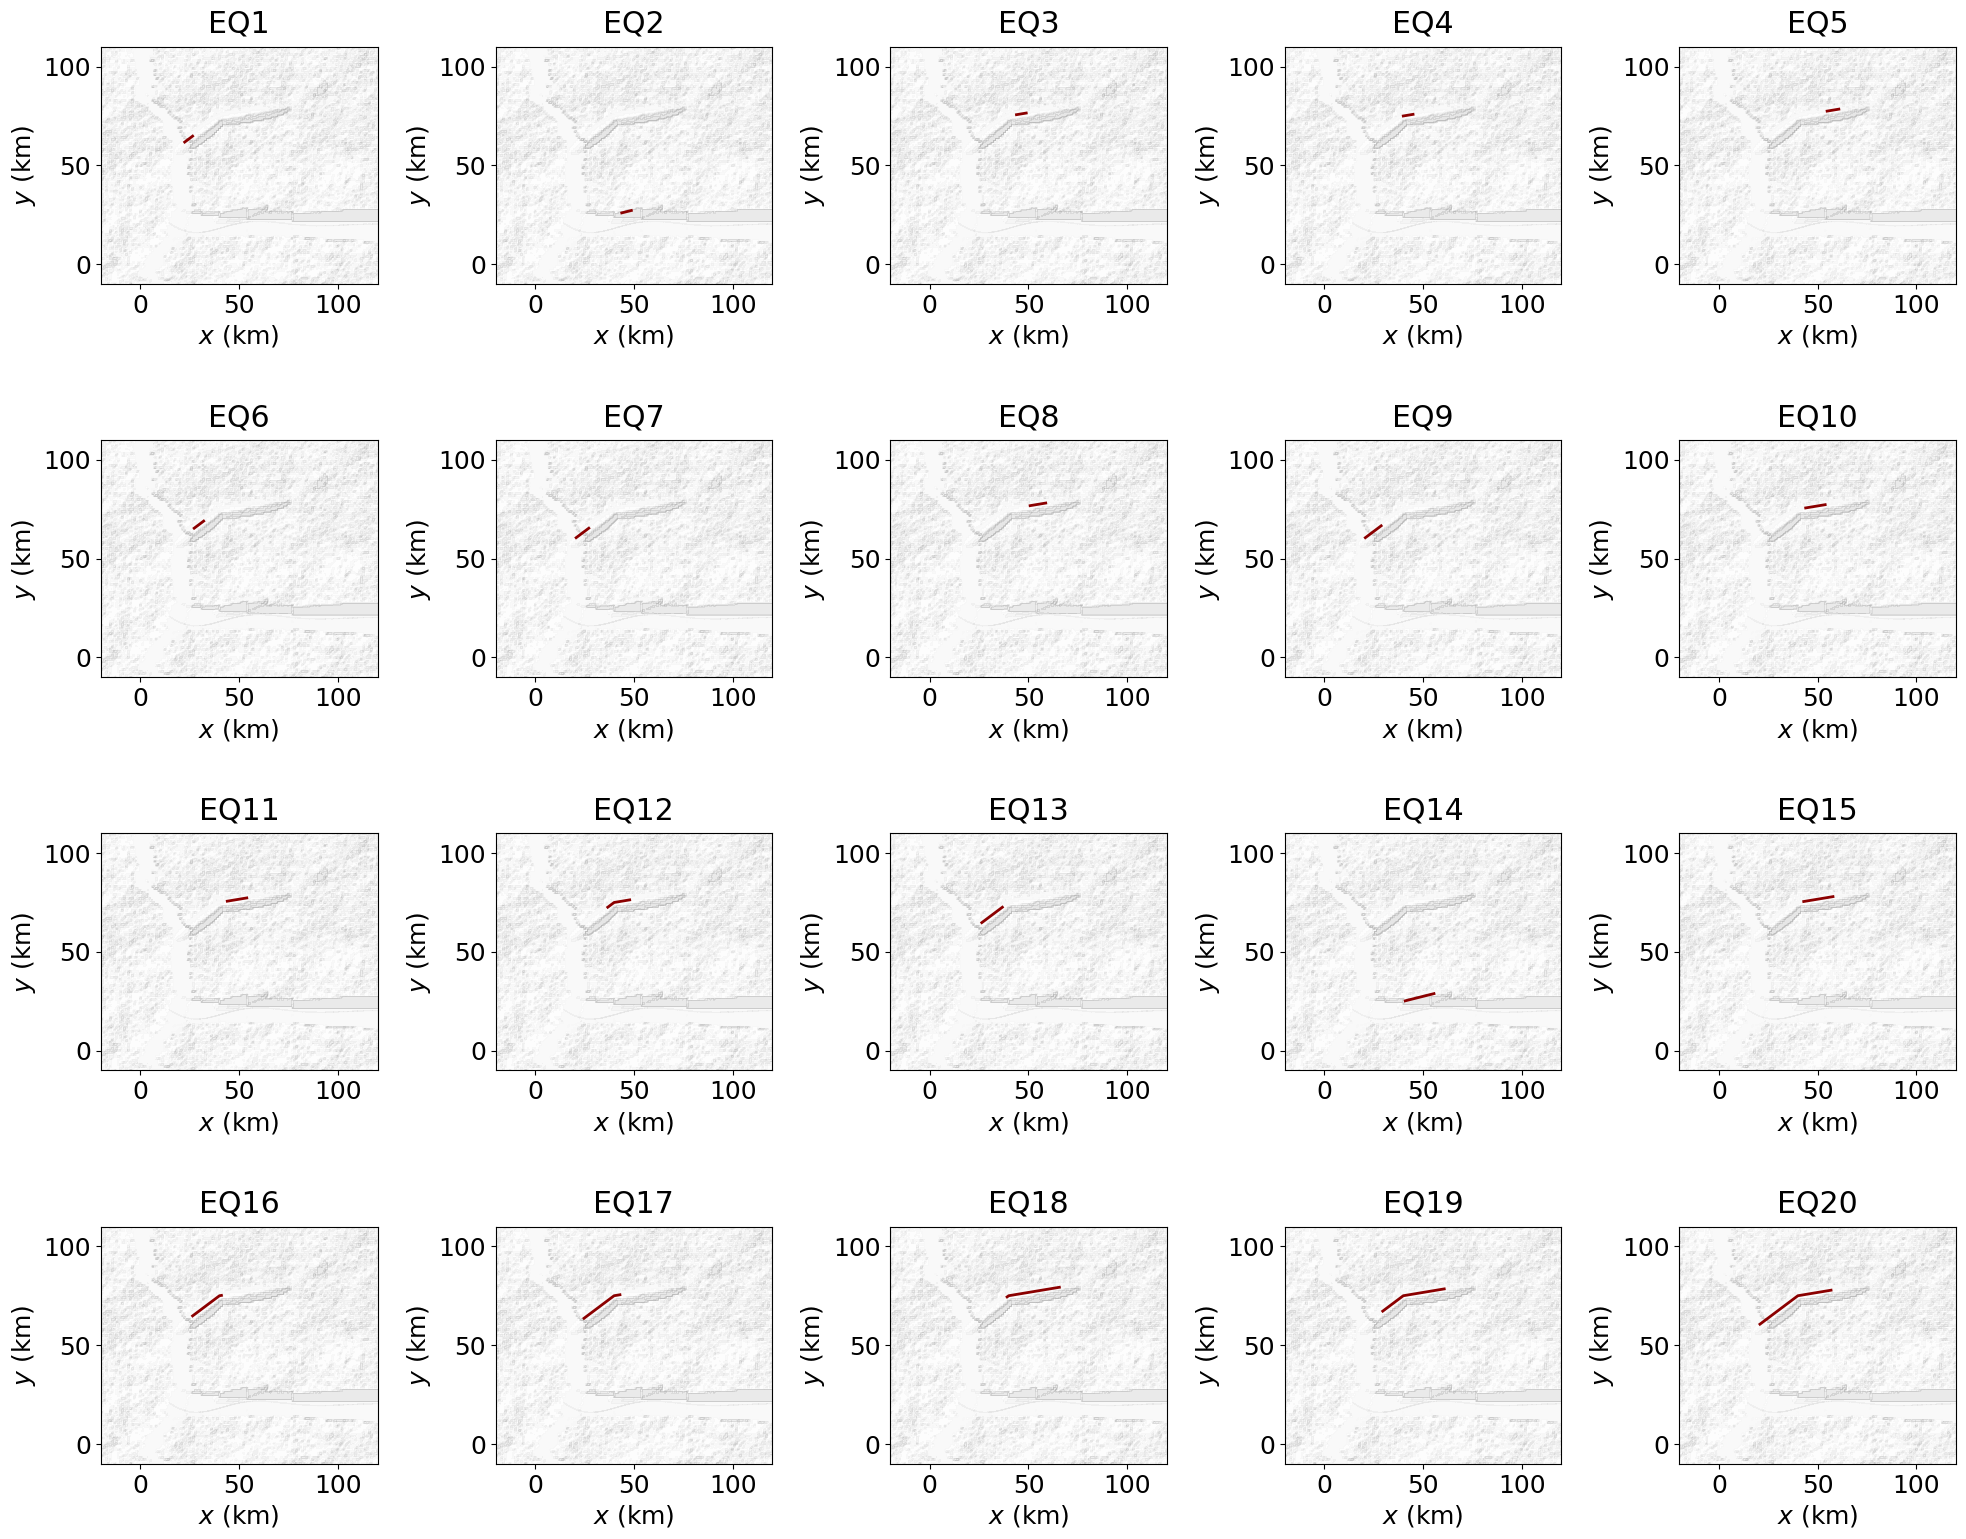

In [4]:
## move to function to plot stochastic events for selected peril...

EQcoord = evchar[GenMR_perils.get_peril_evID(evchar['evID']) == 'EQ'].reset_index(drop = True)
EQi = evtable[evtable['ID'] == 'EQ']['evID'].values

plt.rcParams['font.size'] = '18'
fig, ax = plt.subplots(4, 5, figsize=(20,16))
ax = ax.flatten()
for i in range(sizeDistr['EQ']['Nstoch']):
    EQcoord_evID = EQcoord[EQcoord['evID'] == EQi[i]]
    ax[i].contourf(grid.xx, grid.yy, GenMR_env.ls.hillshade(topoLayer.z, vert_exag=.1), cmap='gray', alpha = .1)
    ax[i].plot(EQcoord_evID['x'], EQcoord_evID['y'], color = 'darkred', linewidth = 2)
    ax[i].set_xlim(grid.xmin, grid.xmax)
    ax[i].set_ylim(grid.ymin, grid.ymax)
    ax[i].set_xlabel('$x$ (km)')
    ax[i].set_ylabel('$y$ (km)')
    ax[i].set_title(EQi[i], pad = 10)
    ax[i].set_aspect(1)
plt.tight_layout()
plt.pause(1)   # to avoid rare case where plot not displayed on notebook
plt.show()

### 1.3. Intensity footprint catalogue generation

Once the stochastic event set has been generated, the next step is to generate one hazard intensity footprint per event.

#### 1.3.1. From analytical expressions & threshold models

Analytical expressions are available to calculate intensity $I(x,y) = f_I(S,r)$ for `AI`/`Ex`, `EQ`, `VE` and `WS`/`TC` (Mignan, 2024:sec. 2.4.1). Size $S$ is available in `stochset` while distance to source $r$ requires to match each event to a source. The match between event and source location is here direct for `AI` and `WS`, where one event occurs per stochastic source. For `VE`, all events occur on the same volcano source. The case of earthquakes is the most complicated since they need to be distributed along the 3 fault segments according to their magnitude (which converts into rupture length).

Equations are taken from Mignan (2024:sec. 2.4.1). Models are defined as `calc_I_*(S,r)` in the Python file.

| ID | Event size $S$ | Intensity $I$ | Equation |
| :--- | :--- | :--- | :--- |
| `AI`, `Ex` | Explosive mass $m_{TNT}$ (kt) | Blast overpressure $P$ (kPa) | Eq. 2.56 |
| `EQ` | Magnitude $M$ | Peak ground acceleration PGA (m/s$^2$) | Eq. 2.54 |
| `TC` | Maximum wind speed $v_{max}$ (m/s) | Wind speed $v$ (m/s) | Eq. 2.24 |
| `VE` | Erupted volume $V$ (km$^3$) | Ash load $P$ (kPa) (converted from thickness (m)) | Eq. 2.61 |

Storm surge (`SS`) is the only peril here for which hazard intensity is estimated from a threshold model (Bathtub model; Mignan, 2024:sec. 2.4.2). The algorithm is kept very simple, and only applies to the present virtual environment where the background topography has an overall West-East orientation (see function `model_SS_Bathtub()`). As a secondary peril triggered by `TC` events, the `SS` size along the coastline is simply taken from a relationship of the form $h_{max} \propto v_{max}^2$ (Mignan, 2024:fig. 2.7) with $v_{max}$ the wind speed along the coastline according to the `TC` footprint.

The catalogue of hazard footprints is generated with the function `gen_hazFootprints()` and plotted with `plot_hazFootprints()`. The rupture coordinates of the stochastic earthquakes are computed in `gen_EQ_floatingRupture()`. The earthquake ruptures are shown below in dark red (rerun cell for different samples):

In [5]:
# additional atmospheric source parameters -> CONSIDER MOVING TO NEW ENV. LAYER
src.par['TC']['vforward_m/s'] = 10  # forward storm speed [m/s]    
src.par['TC']['pn_mbar'] = 1005     # ambient pressure [mbar]
src.par['TC']['B_Holland'] = 2      # Holland's parameter (see Fig. 2.10 of textbook)
src.par['TC']['lat_deg'] = grid.lat_deg   # average latitude of digital template (see Tutorial 1)

# virtual region bathymetry characteristics for SS height given storm wind speed
src.par['SS']['bathy'] = 'New York harbor'  # 'generic' (Saffir-Simpson, Mignan, 2024:eq. 2.16) 
                                            # 'New York harbor' (Eq. in Mignan, 2024:fig. 2.7)

hazFootprints = GenMR_perils.HazardFootprintGenerator(evtable, evchar, src, topoLayer.z)
catalog_hazFootprints = hazFootprints.generate()

generating footprints for: AI, EQ, RS, TC, 

/Users/arnaudmignan/Documents/GmbH_MRA/2_fundedR&D/2025-2027_GenMR_SCOR/GenMR_SCOR/GenMR/perils.py:601: RuntimeWarning: divide by zero encountered in divide
  alpha = np.arctan(dy / dx)
/Users/arnaudmignan/Documents/GmbH_MRA/2_fundedR&D/2025-2027_GenMR_SCOR/GenMR_SCOR/GenMR/perils.py:601: RuntimeWarning: divide by zero encountered in divide
  alpha = np.arctan(dy / dx)
/Users/arnaudmignan/Documents/GmbH_MRA/2_fundedR&D/2025-2027_GenMR_SCOR/GenMR_SCOR/GenMR/perils.py:601: RuntimeWarning: divide by zero encountered in divide
  alpha = np.arctan(dy / dx)
/Users/arnaudmignan/Documents/GmbH_MRA/2_fundedR&D/2025-2027_GenMR_SCOR/GenMR_SCOR/GenMR/perils.py:601: RuntimeWarning: divide by zero encountered in divide
  alpha = np.arctan(dy / dx)
/Users/arnaudmignan/Documents/GmbH_MRA/2_fundedR&D/2025-2027_GenMR_SCOR/GenMR_SCOR/GenMR/perils.py:601: RuntimeWarning: divide by zero encountered in divide
  alpha = np.arctan(dy / dx)


VE, FF, LS, SS, Ex, ... catalogue completed


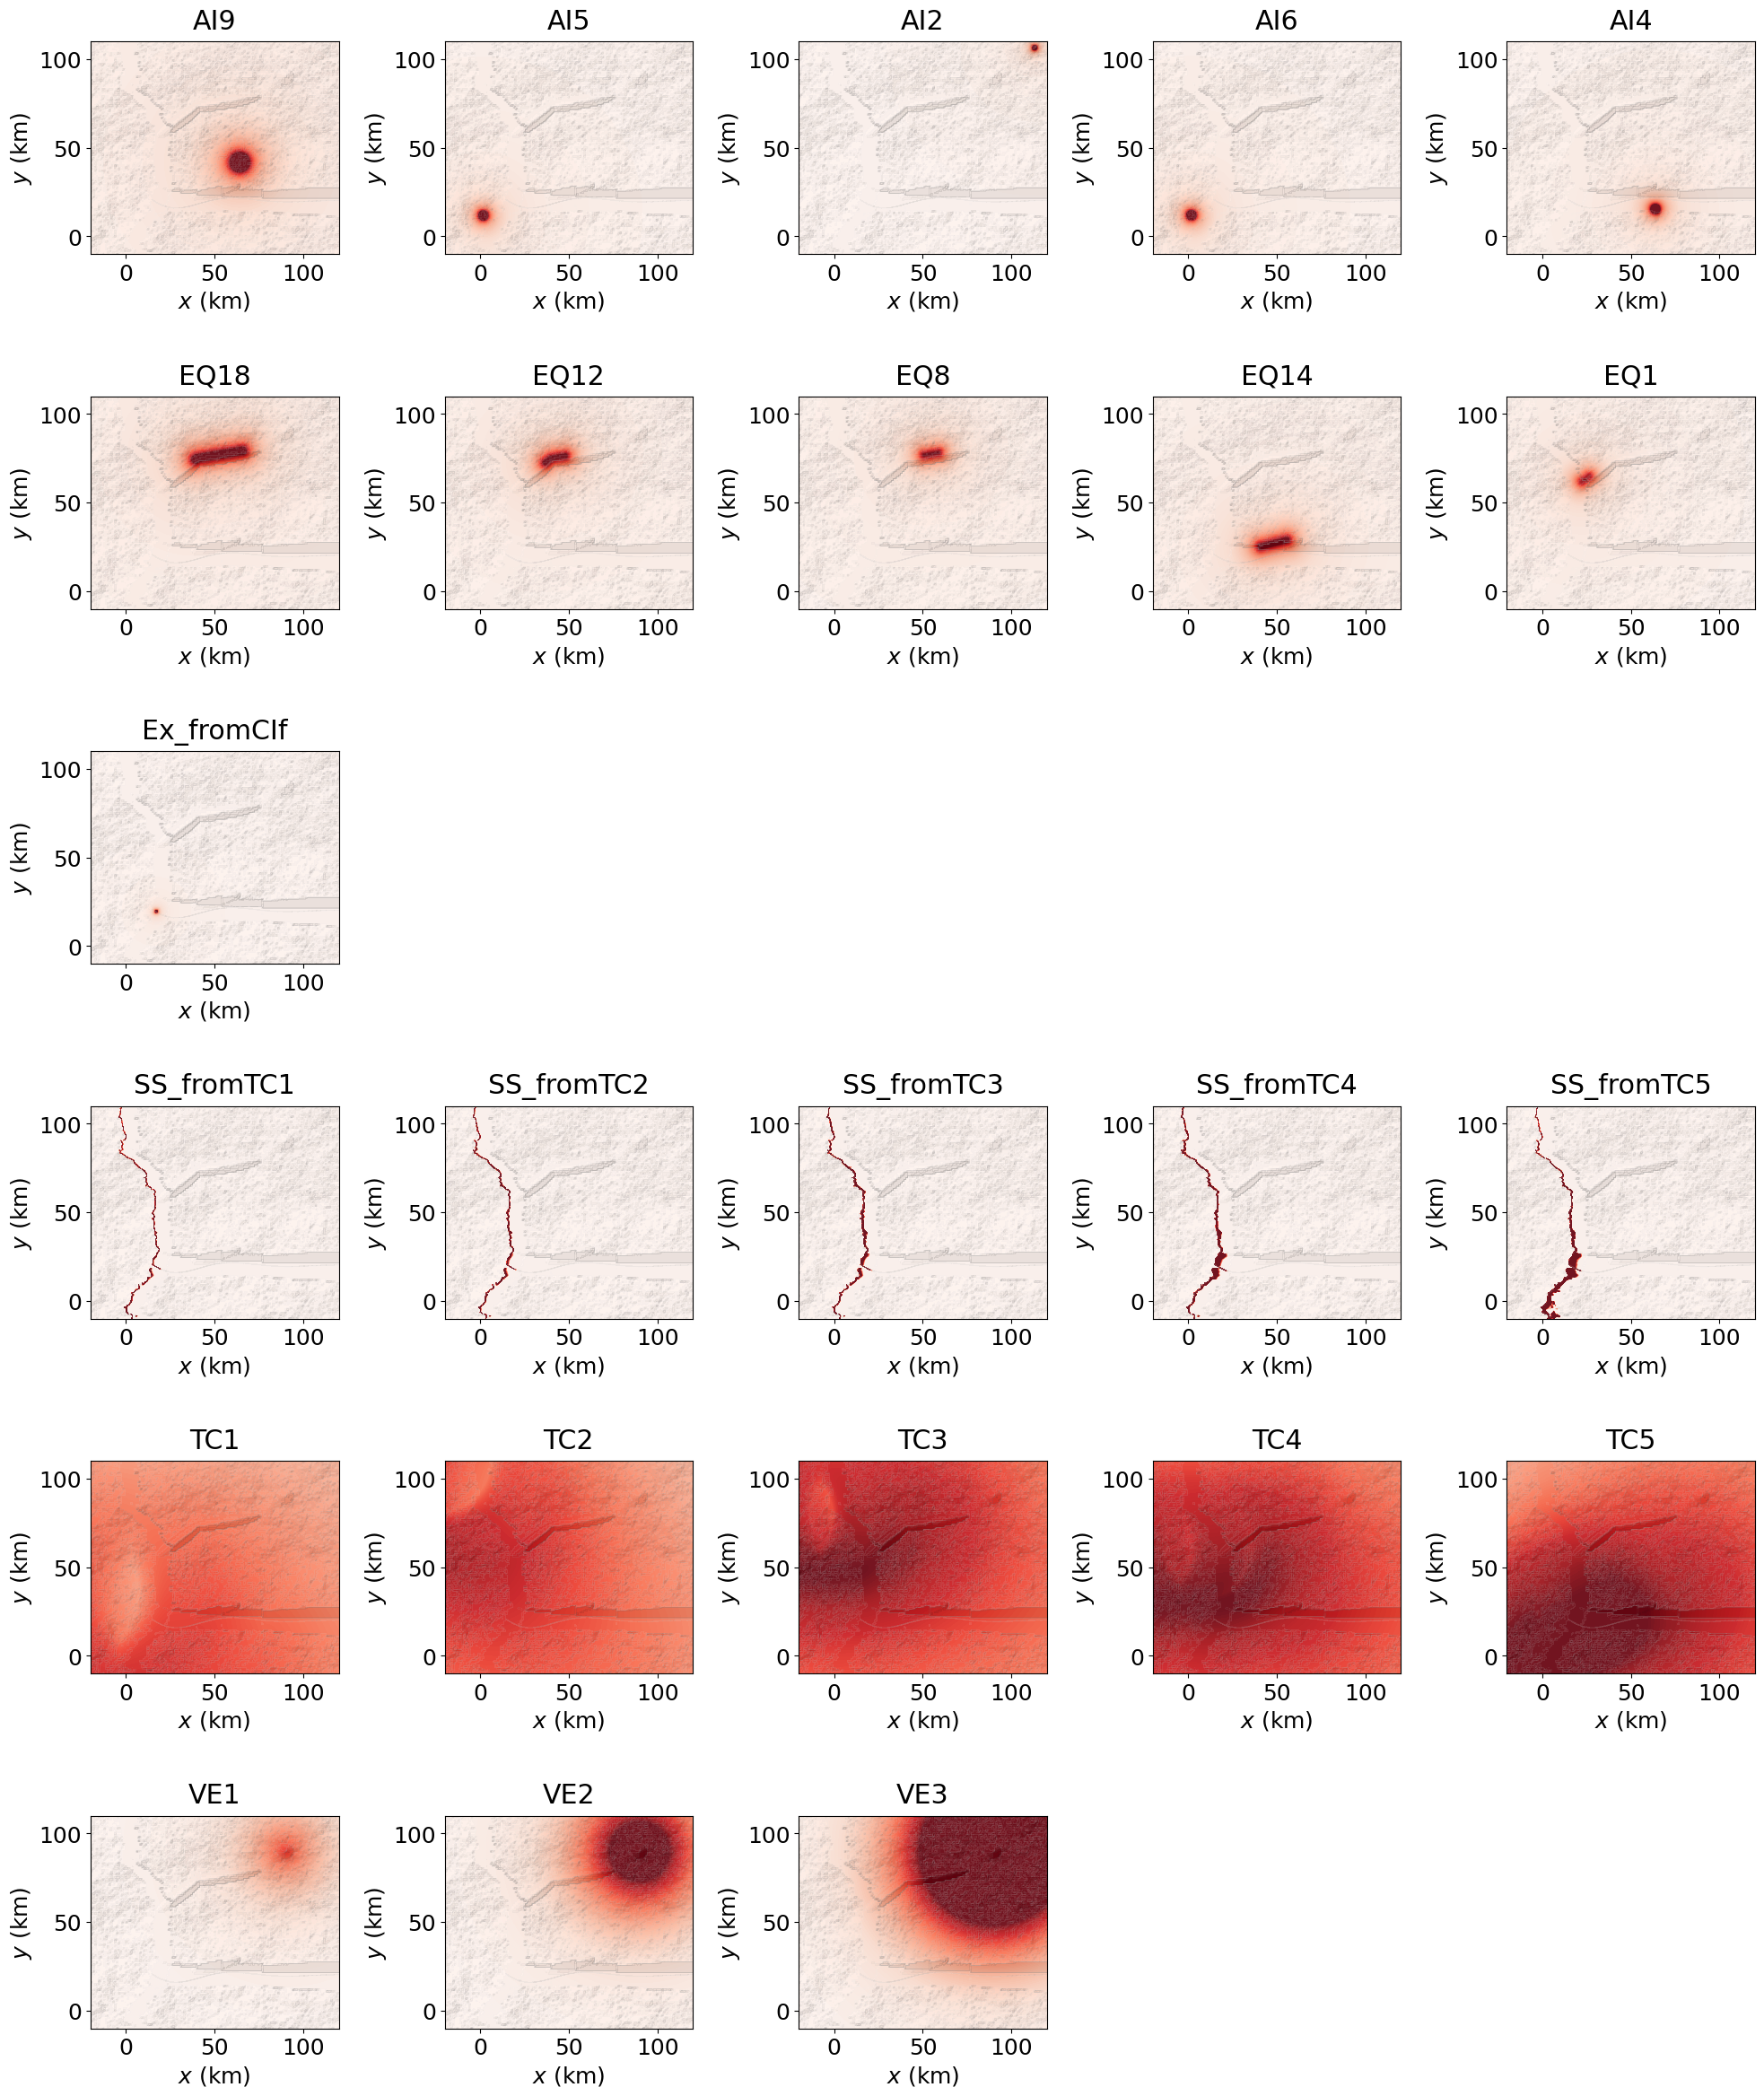

In [11]:
# max intensity Imax in color range [see units in previous table]
# to compare similar levels of expected damage, choose a value per peril for a constant MDR in the vulnerability
# curves (see curves generated by plot_vulnFunctions())
Imax_Ex_totaldestruction = 4 * 6.89476  # kPa (here 4 psi as threshold of total destruction)

plot_Imax = {'AI': Imax_Ex_totaldestruction, 'EQ': 6, 'Ex': Imax_Ex_totaldestruction, 'LS': 2., \
             'SS': 2., 'TC': 70., 'VE': .5}

# nstoch (default = 5) defines the number of events per peril to be displayed by row
# if the number of events > nstoch, footprints are randomly sampled from all possibilities
GenMR_perils.plot_hazFootprints(catalog_hazFootprints, grid, topoLayer.z, plot_Imax)  #, nstoch = 5)

**Note:** Observe the `TC` footprint boundary effect (cyclonic eye), which is due to the track artificially starting at `grid.xmin`.

#### 1.3.2. From numerical models (cellular automata)

Generation of hazard intensity footprints via dynamical processes (here cellular automata) is kept separate since they are computationally costly. All footprints are combined later on ... REWRITE/DEVELOP

ADD table for LS, FF...

The following movie is obtained by running `LS_CA.write_gif()`. It shows the landslide propagation over time generated by the cellular automaton. The final hazard intensity footprint to be listed in the hazard footprint catalogue is static and equal to $\max_t I(x,y,t)$.

<img src="movs/LS_CA_xrg38_68_yrg20_35.gif" width = 500>


In [8]:
reproduce_LSmovie = False          # True to create 'movs/LS_CA_xrg38_68_yrg20_35.gif'
reproduce_FFmovie = False          # True to create 'movs/FF_CA_xrg0_100_yrg0_40.gif'

if reproduce_LSmovie:
    movie = {'create': True, 'xmin': 38, 'xmax': 68, 'ymin': 20, 'ymax': 35}   # zoom on specific hill

    evID_trigger = 'RS3'                                       # case considered for movie scenario
    S_trigger = evtable['S'][evtable['evID'] == evID_trigger].values
    hw = S_trigger * 1e-3 * src.par['RS']['duration']          # water column (m)
    wetness = hw / soilLayer.h
    wetness[wetness > 1] = 1                                   # max possible saturation
    wetness[soilLayer.h == 0] = 0                              # no soil case

    LS_CA = GenMR_perils.CellularAutomaton_LS(soilLayer, wetness, movie)
    LS_CA.run()
    LS_CA.write_gif()
    print('LS movie created (go to mov/LS_CA_*).')
else:
    print('No LS movie created.')
    
if reproduce_FFmovie:
    I_RS = evtable[evtable['evID'] == 'RS3']['S'].values[0] * 1e-3 / 3600    # (mm/hr) to (m/s)
    movie = {'create': True, 'xmin': 0, 'xmax': 100, 'ymin': 0, 'ymax': 40, 'tmin': 40} 

    FF_CA = GenMR_perils.CellularAutomaton_FF(I_RS, src, grid, topoLayer.z, movie)
    FF_CA.run()
    FF_CA.write_gif()
    print('FF movie created (go to mov/FF_CA_*).')
else:
    print('No FF movie created.')

No LS movie created.
No FF movie created.


Generate all dynamical intensity footprints at once with `dynhazFootprints.generate()`. To run a specific list of perils, use instead `dynhazFootprints.generate(selected_perils = ['LS', 'FF', ...])`. Note that if a peril has already be run, cached footprints will be directly loaded. To force recomputing, add the option `force_recompute = True` within the function.

In [9]:
dynhazFootprints = GenMR_perils.DynamicHazardFootprintGenerator(evtable, src, soilLayer)
catalog_dynhazFootprints = dynhazFootprints.generate()
#_ = dynhazFootprints.generate(selected_perils = ['LS'], force_recompute = True)
#catalog_dynhazFootprints = dynhazFootprints.generate(selected_perils = ['FF'], force_recompute = True)
catalog_dynhazFootprints.keys()

generating footprints for:
FF_fromRS1 (loaded from cache)
FF_fromRS2 (loaded from cache)
FF_fromRS3 (loaded from cache)
LS_fromRS1 (loaded from cache)
LS_fromRS2 (loaded from cache)
LS_fromRS3 (loaded from cache)
... catalogue completed


dict_keys(['FF_fromRS1', 'FF_fromRS2', 'FF_fromRS3', 'LS_fromRS1', 'LS_fromRS2', 'LS_fromRS3'])

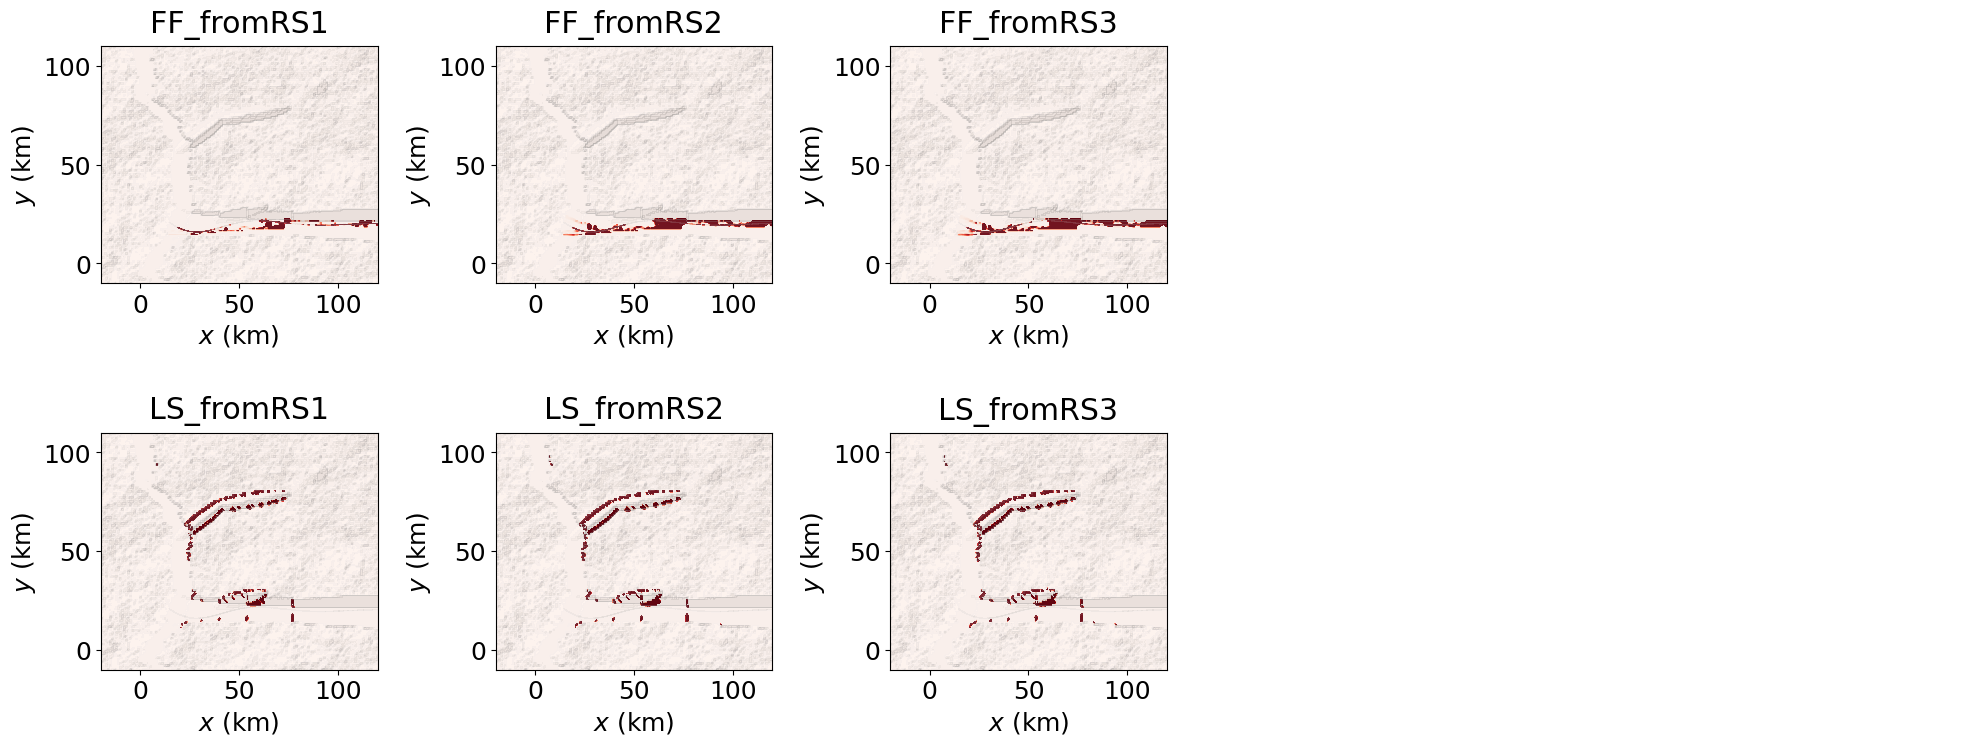

In [10]:
plot_Imax = {'LS': 2, 'FF': 1}

catalog_dynhazFootprints = dynhazFootprints.catalog_hazFootprints
GenMR_perils.plot_hazFootprints(catalog_dynhazFootprints, grid, topoLayer.z, plot_Imax)

## References

TO ADD


## Appendix

### A. Peril sources

ADD TABLE giving source class properties

### B. Stochastic event set

TO DEVELOP

### C. Hazard footprints

TO DEVELOP

#### C.1. Tropical cyclone case

If the modelling of `AI`, `EQ` and `VE` intensity footprints is straightforward, this is not the case for `TC`. For completeness, windfields can be plotted at a given time - REWRITE...

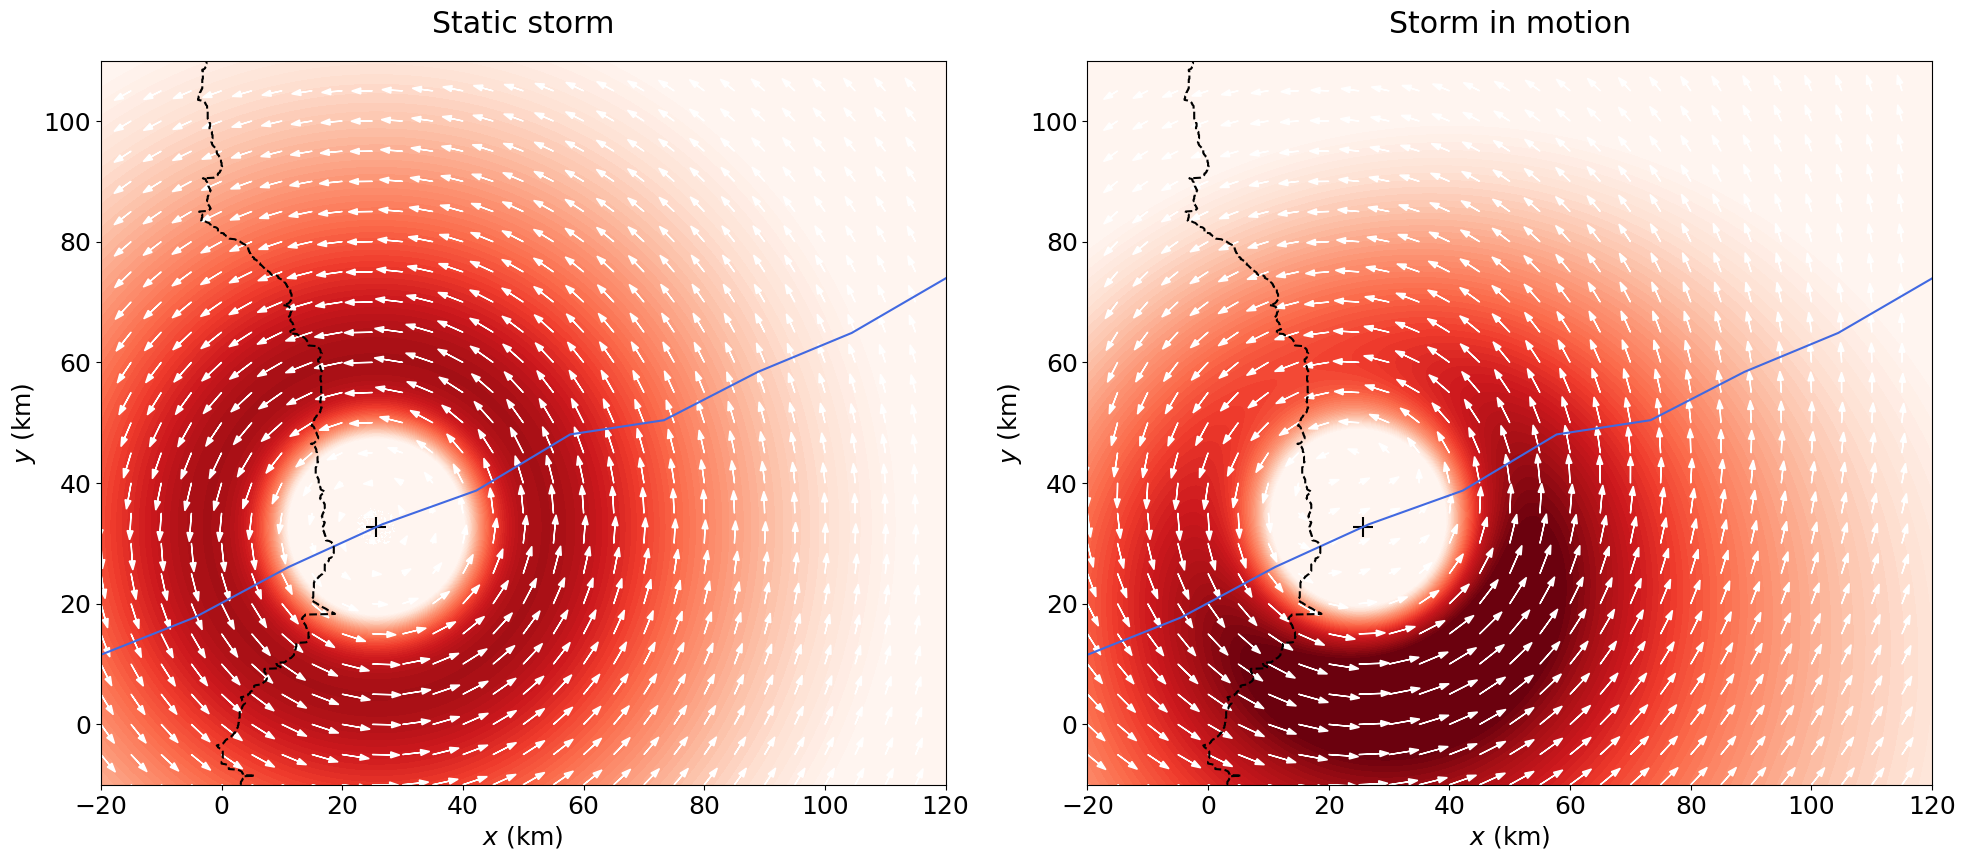

In [19]:
evID = 'TC5'     # choose a TC event
loc_x = 25.      # location of time snapshot (km)


track_evID = evchar[evchar['evID'] == evID]
t_snapshot = np.where(track_evID['x'] > loc_x)[0][0]

I_sym_t, I_asym_t, vtot_x, vtot_y, vtan_x, vtan_y = hazFootprints.get_TC_timeshot(evID, t_snapshot)


plt.rcParams['font.size'] = '18'
fig, ax = plt.subplots(1, 2, figsize=(20,10))

Imax = plot_Imax['TC']
I_plt = np.copy(I_sym_t)
I_plt[I_plt >= Imax] = Imax
ax[0].contourf(grid.xx, grid.yy, I_plt, cmap = 'Reds', levels = np.linspace(0, Imax, 100), vmin=33, vmax=Imax)
ax[0].plot(track_evID['x'], track_evID['y'], color = GenMR_utils.col_peril('TC'))
ax[0].plot(src.SS_char['x'], src.SS_char['y'], color = 'black', linestyle = 'dashed')
ax[0].scatter(track_evID['x'].values[t_snapshot], track_evID['y'].values[t_snapshot], marker = '+', \
              color = 'black', s = 200)
delta = 50
for i in range(int(grid.xx.shape[0]/delta)):
    for j in range(int(grid.xx.shape[1]/delta)):
        ax[0].arrow(grid.xx[delta*i,delta*j], grid.yy[delta*i,delta*j], 
            .05 * vtan_x[delta*i,delta*j], .05* vtan_y[delta*i,delta*j], head_width = 1, color = 'white')
ax[0].set_xlabel('$x$ (km)')
ax[0].set_ylabel('$y$ (km)')
ax[0].set_title('Static storm', pad = 20)
ax[0].set_xlim(grid.xmin, grid.xmax)
ax[0].set_ylim(grid.ymin, grid.ymax)
ax[0].set_aspect(1)

I_plt = np.copy(I_asym_t)
I_plt[I_plt >= Imax] = Imax
ax[1].contourf(grid.xx, grid.yy, I_plt, cmap = 'Reds', levels = np.linspace(0, Imax, 100), vmin=33, vmax=Imax)
ax[1].plot(track_evID['x'], track_evID['y'], color = GenMR_utils.col_peril('TC'))
ax[1].plot(src.SS_char['x'], src.SS_char['y'], color = 'black', linestyle = 'dashed')
ax[1].scatter(track_evID['x'].values[t_snapshot], track_evID['y'].values[t_snapshot], marker = '+', \
              color = 'black', s = 200)
delta = 50
for i in range(int(grid.xx.shape[0]/delta)):
    for j in range(int(grid.xx.shape[1]/delta)):
        ax[1].arrow(grid.xx[delta*i,delta*j], grid.yy[delta*i,delta*j], 
            .05 * vtot_x[delta*i,delta*j], .05* vtot_y[delta*i,delta*j], head_width = 1, color = 'white')
ax[1].set_xlabel('$x$ (km)')
ax[1].set_ylabel('$y$ (km)')
ax[1].set_title('Storm in motion', pad = 20)
ax[1].set_xlim(grid.xmin, grid.xmax)
ax[1].set_ylim(grid.ymin, grid.ymax)
ax[1].set_aspect(1)
plt.tight_layout();